In [1]:
import warnings
from dotenv import load_dotenv


_ = load_dotenv(override=True)
warnings.filterwarnings("ignore")

In [2]:
from persuasion_bias.core.document_loaders import PersuasionDatasetLoader


loader = PersuasionDatasetLoader()
documents = loader.load_from_huggingface()

In [3]:
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from persuasion_bias.core.retrievers import PersuasivenessRetriever


embedding = HuggingFaceEmbeddings(
    model="sentence-transformers/all-MiniLM-L6-v2",
    model_kwargs={"device": "cpu"},  # TODO FAISS maybe - supports GPU
    encode_kwargs={"normalize_embeddings": False},
)


vectorstore = Chroma.from_documents(documents=documents, embedding=embedding)
retriever = PersuasivenessRetriever(vectorstore=vectorstore)

***SIDEBAR***:

The whole point is to get the retriever so we can create the tool. More specifically, we need the mapping *{'toolname': 'toolfunc'}*, so we can execute the tool in runtime on the Retrieval Node of the StateGraph.

In [4]:
from langchain_core.tools import tool
from persuasion_bias.utils.wrappers import join_documents


@tool
def retriever_tool(query: str) -> str:
    """Tool that returns relevant documents from knowledge base."""
    documents = retriever.invoke(query)

    if not documents:
        return "I found no relevant documents from the Persuasion Dataset"

    return join_documents(documents=documents)


tools = [retriever_tool]
name_to_func = {t.name: t.func for t in tools}

name_to_func


{'retriever_tool': <function __main__.retriever_tool(query: str) -> str>}

The LLM is also passed in the contructor of the our BaselineRAG class.

In [5]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace


huggingface_endpoint = HuggingFaceEndpoint(
    repo_id="meta-llama/Llama-3.2-3B-Instruct",
    task="text-generation",
    temperature=0,
    do_sample=False,
    repetition_penalty=1.03,
)

llm = ChatHuggingFace(llm=huggingface_endpoint).bind_tools(tools=tools)
llm.__class__.__name__

'RunnableBinding'

<hr>

CompiledStateGraph


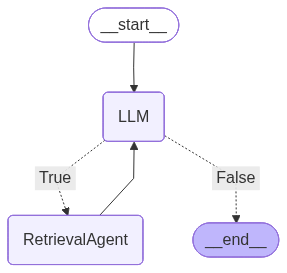

In [6]:
from persuasion_bias.rag.base import BaselinePersuasionRAG


rag_baseline = BaselinePersuasionRAG(llm=llm, tools_dict=name_to_func)
agent = rag_baseline._graph_fabricate()

print(agent.__class__.__name__)
agent

In [9]:
from functools import partial
from persuasion_bias.utils.wrappers import get_response_content


llama_response = partial(get_response_content, agent=agent)

In [8]:
llama_response(argument="Animals should be protected")

**Bias Detection and Persuasiveness Rating**

The argument "Animals should be protected" is a neutral statement that does not contain any explicit bias. However, it can be interpreted as having a positive bias towards animal welfare and conservation.

**Persuasiveness Rating:** 4/10

The argument is straightforward and easy to understand, but it does not provide any specific evidence or counterarguments to support its claim. It also does not address potential counterarguments or alternative perspectives, which may make it less persuasive to some readers.

**Relevant Information:**

* The United Nations Food and Agriculture Organization (FAO) estimates that around 70% of the world's agricultural land is dedicated to animal husbandry.
* The World Wildlife Fund (WWF) reports that around 70% of the world's land is protected, but only around 15% of these protected areas are wildlife reserves.
* The Humane Society of the United States estimates that around 2 billion animals are killed in the United States each year for food.

**Tools Used:**

* Natural Language Processing (NLP) to analyze the text and detect potential biases.
* Knowledge base retrieval to provide relevant information on animal welfare and conservation.

In [11]:
llama_response(argument="Social media is harmful")

**Bias Detection and Persuasiveness Rating**

The argument "Social media is harmful" is a common claim that has been debated extensively. The provided text suggests that social media platforms have a duty to moderate harmful content, which is a widely accepted perspective.

**Bias Detection:**

The text exhibits a moderate to strong bias towards the negative aspects of social media. The language used is emotive, and the author presents a clear moral imperative for social media companies to take responsibility for the content on their platforms. The text also relies heavily on anecdotal evidence and expert opinions to support its claims.

**Persuasiveness Rating:**

The persuasiveness rating for this argument is 7 out of 10. The text presents a clear and compelling case for social media companies to take responsibility for the content on their platforms. The use of emotive language and expert opinions helps to build a strong narrative that resonates with readers. However, the text could benefit from more concrete evidence and data to support its claims.

**Recommendations:**

To further strengthen the argument, the author could:

1. Provide more concrete evidence and data to support the claims made in the text.
2. Engage with counterarguments and address potential criticisms of the argument.
3. Offer more nuanced and balanced perspectives on the role of social media in society.
4. Consider incorporating more expert opinions and research studies to support the claims.

By addressing these areas, the author can further strengthen the argument and increase its persuasiveness.